In [30]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import deeplenstronomy.deeplenstronomy as dl

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, PowerTransformer
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from pathlib import Path
from astropy.stats import sigma_clip, sigma_clipped_stats

In [31]:
def vis_random_dist(data, vmin = 0, vmax = 10, seed = None,):
    fig, axs = plt.subplots(2, 4, figsize=(10, 5))

    if seed is not None:
        np.random.seed(seed)
    
    # Generate random i values between 1 and 100
    i_values = np.random.randint(1, 101, size=(4, 4))
    normalizer = Normalize(vmin = vmin, vmax = vmax)
    im = cm.ScalarMappable(norm = normalizer)
    for i in range(2):
        for j in range(4):
            title = axs[i, j].set_title("i = " + str(i_values[i, j]))
            k = axs[i, j].imshow(data[i_values[i, j]], norm = normalizer)
            axoff = axs[i, j].axis('off')

    a = plt.tight_layout()
    a = plt.colorbar(im, ax=axs.ravel().tolist())
    return fig, axs

def get_random_dist(data):
    # Set the random seed for reproducibility
    np.random.seed(0)

    # Generate random i values between 1 and 100
    i_values = np.random.randint(1, 101, size=(4, 4))

    # Create a 4x4 grid of subplots
    fig, axs = plt.subplots(4, 4, figsize=(12, 12))

    # Iterate over the subplots and plot the histograms
    for i in range(4):
        for j in range(4):
            # Get the normalized_source for the current i value
            normalized_source_i = data[i_values[i, j]]
            
            # Plot the histogram
            a = axs[i, j].hist(normalized_source_i.flatten(), bins=20, color='blue', alpha=0.7)
            b = axs[i, j].set_title(f'i = {i_values[i, j]}')
            c = axs[i, j].set_xlabel('Normalized Target')
            d = axs[i, j].set_ylabel('Frequency')

    # Adjust the spacing between subplots
    plt.tight_layout()

    return fig, axs

In [33]:
head = Path.cwd().parent
datapath = head / 'src/sim/data'
source = np.load(datapath / 'pax_orig_source/pax_orig_source.npy')[:, 0, :, :]
src_md = pd.read_csv(datapath / 'pax_orig_source/paxnorm_orig_source_metadata.csv')
target = np.load(datapath / 'pax_target/pax_target.npy')[:, 0, :, :]
target_md = pd.read_csv(datapath / 'pax_target/paxnorm_target_metadata.csv')

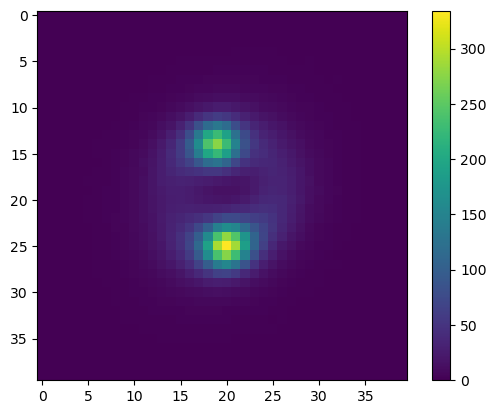

In [34]:
plt.imshow(source[57])
plt.colorbar()

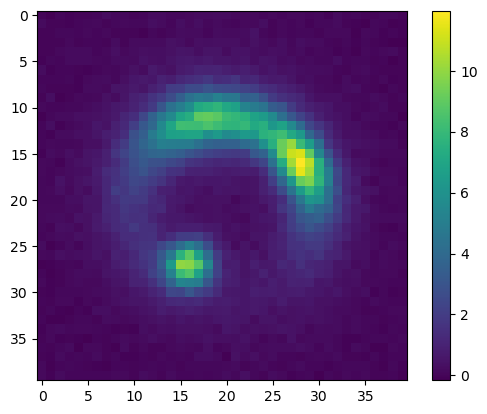

In [35]:
plt.imshow(target[62])
plt.colorbar()

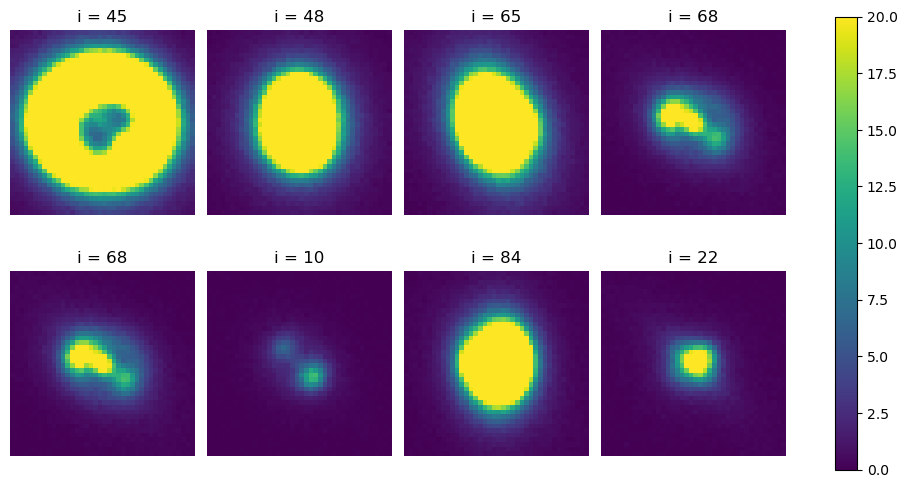

In [36]:
fig, axs = vis_random_dist(source, vmin = 0, vmax = 20, seed = 0)


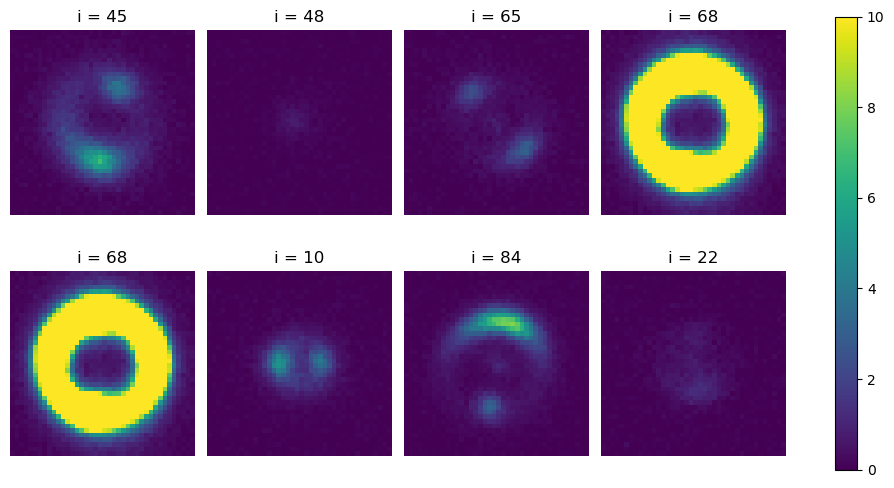

In [37]:
fig, axs = vis_random_dist(target, vmin = 0, vmax = 10, seed = 0)


In [38]:
def get_clipped_stats(data, sigma):
    scs = sigma_clipped_stats(data, sigma=sigma, axis = (1, 2))
    return scs

source_clipped_stats = get_clipped_stats(source, 2)[1] # mean, MEDIAN, std
target_clipped_stats = get_clipped_stats(target, 2)[1] # mean, MEDIAN, std

In [39]:
clipped_source = (source - source_clipped_stats[:, np.newaxis, np.newaxis])
clipped_target = (target - target_clipped_stats[:, np.newaxis, np.newaxis])

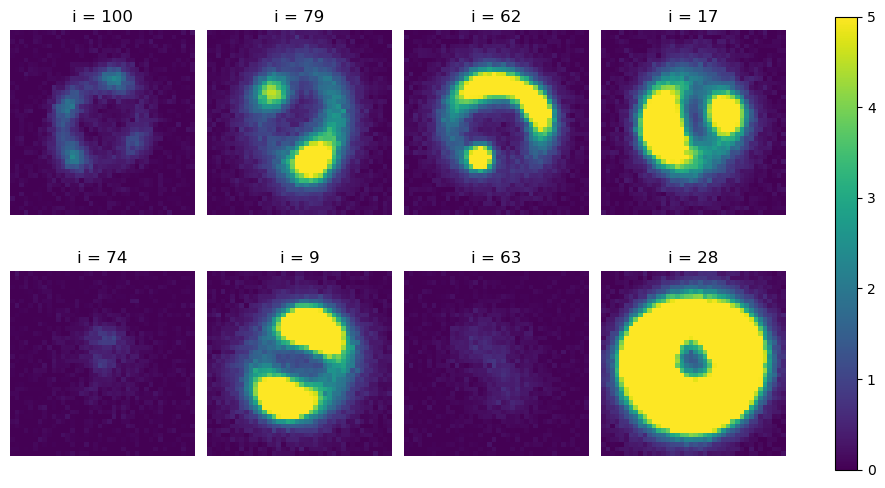

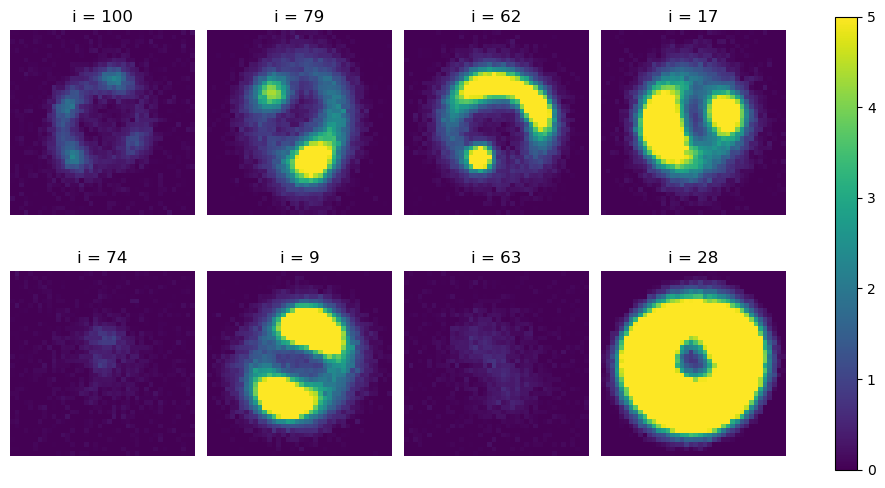

In [40]:
fig, axs = vis_random_dist(target, vmin = 0, vmax = 5, seed = 5)
fig, axs = vis_random_dist(clipped_target, vmin = 0, vmax = 5, seed = 5)

In [41]:
def normalize_robust(data):
    log_data = np.log1p(data)
    scaler = RobustScaler()
    normalized_data = scaler.fit_transform(log_data.reshape(-1, 1)).reshape(data.shape)
    return normalized_data

def normalize_minmax(data):
    log_data = np.log1p(data)
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(log_data.reshape(-1, 1)).reshape(data.shape)
    return normalized_data

In [42]:
normalized_source = normalize_minmax(source)
normalized_target = normalize_minmax(target)
normalized_clipped_target = normalize_minmax(clipped_target)

(<Figure size 1000x500 with 9 Axes>,
 array([[<AxesSubplot:title={'center':'i = 25'}>,
         <AxesSubplot:title={'center':'i = 4'}>,
         <AxesSubplot:title={'center':'i = 57'}>,
         <AxesSubplot:title={'center':'i = 73'}>],
        [<AxesSubplot:title={'center':'i = 1'}>,
         <AxesSubplot:title={'center':'i = 22'}>,
         <AxesSubplot:title={'center':'i = 20'}>,
         <AxesSubplot:title={'center':'i = 75'}>]], dtype=object))

(<Figure size 1000x500 with 9 Axes>,
 array([[<AxesSubplot:title={'center':'i = 25'}>,
         <AxesSubplot:title={'center':'i = 4'}>,
         <AxesSubplot:title={'center':'i = 57'}>,
         <AxesSubplot:title={'center':'i = 73'}>],
        [<AxesSubplot:title={'center':'i = 1'}>,
         <AxesSubplot:title={'center':'i = 22'}>,
         <AxesSubplot:title={'center':'i = 20'}>,
         <AxesSubplot:title={'center':'i = 75'}>]], dtype=object))

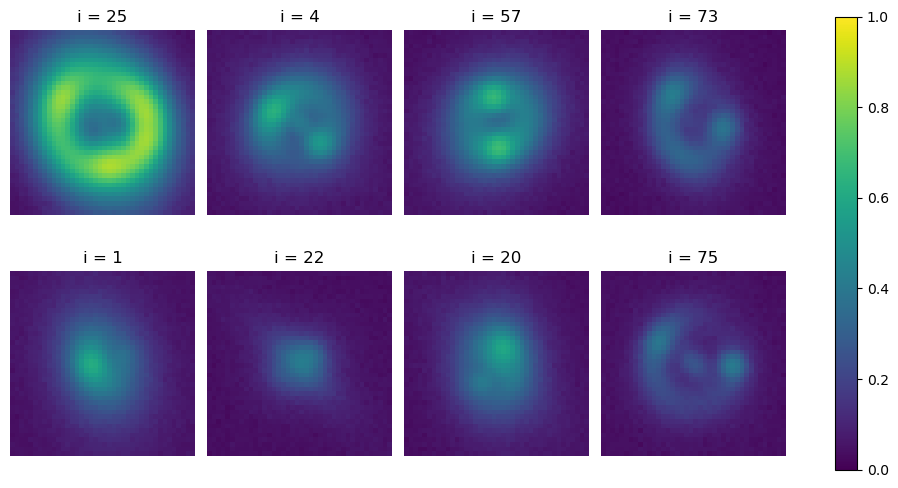

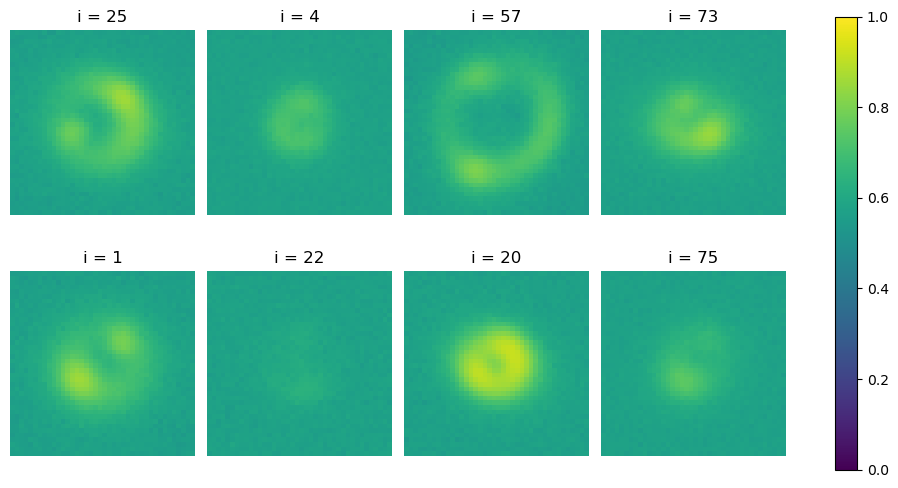

In [24]:
vis_random_dist(normalized_source, seed = 3, vmin = 0, vmax = 1)
vis_random_dist(normalized_clipped_target, seed = 3, vmin = 0, vmax = 1)

(array([266., 466., 272., 129.,  79.,  54.,  56.,  44.,  46.,  25.,  32.,
         14.,  18.,  23.,  13.,  19.,  18.,  12.,  10.,   4.]),
 array([0.02303978, 0.04178268, 0.06052557, 0.07926846, 0.09801135,
        0.11675424, 0.13549713, 0.15424002, 0.17298291, 0.1917258 ,
        0.21046869, 0.22921158, 0.24795447, 0.26669736, 0.28544025,
        0.30418314, 0.32292603, 0.34166892, 0.36041181, 0.3791547 ,
        0.39789759]),
 <BarContainer object of 20 artists>)

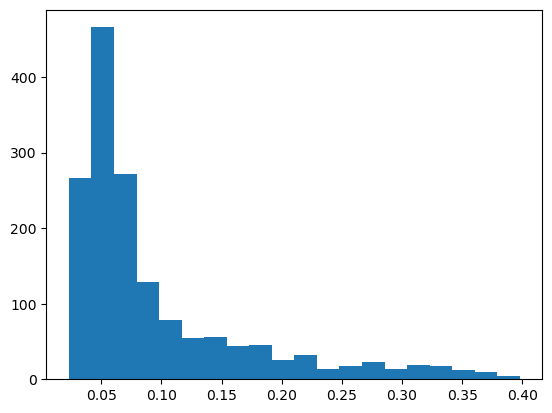

In [25]:
plt.hist(normalized_source[5].flatten(), bins = 20)

(array([  1.,   5.,  36., 127., 305., 378., 324., 178.,  85.,  52.,  20.,
         19.,  15.,  11.,  11.,  12.,   8.,   8.,   2.,   3.]),
 array([0.15531509, 0.16523785, 0.17516061, 0.18508337, 0.19500613,
        0.20492889, 0.21485165, 0.22477442, 0.23469718, 0.24461994,
        0.2545427 , 0.26446546, 0.27438822, 0.28431098, 0.29423374,
        0.30415651, 0.31407927, 0.32400203, 0.33392479, 0.34384755,
        0.35377031]),
 <BarContainer object of 20 artists>)

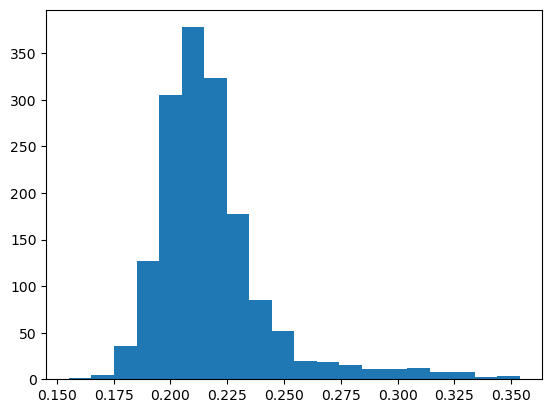

In [26]:
plt.hist(normalized_target[6].flatten(), bins = 20)

In [27]:
np.save(datapath / 'pax_orig_source/paxnorm_orig_source.npy', normalized_source)
np.save(datapath / 'pax_target/paxnorm_target.npy', normalized_target)

(array([146., 724., 236.,  80.,  51.,  48.,  28.,  24.,  28.,  17.,  20.,
         19.,   9.,  21.,  23.,  23.,  35.,  24.,  26.,  18.]),
 array([0.16141511, 0.19563185, 0.22984859, 0.26406533, 0.29828207,
        0.33249881, 0.36671555, 0.40093229, 0.43514903, 0.46936577,
        0.50358251, 0.53779925, 0.57201599, 0.60623273, 0.64044947,
        0.67466621, 0.70888295, 0.74309969, 0.77731643, 0.81153317,
        0.84574991]),
 <BarContainer object of 20 artists>)

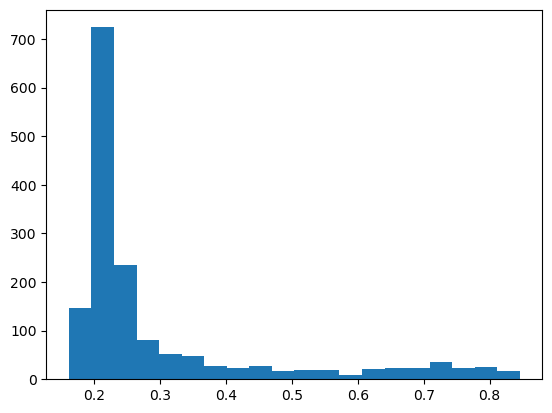

In [28]:
plt.hist(normalized_target[20].flatten(), bins = 20)

(array([1321.,   59.,   36.,   14.,   19.,   18.,   13.,   14.,   18.,
          14.,   12.,   11.,   10.,   10.,    4.,    9.,    6.,    4.,
           5.,    3.]),
 array([-0.23869085,  2.72525734,  5.68920553,  8.65315371, 11.6171019 ,
        14.58105009, 17.54499828, 20.50894647, 23.47289465, 26.43684284,
        29.40079103, 32.36473922, 35.32868741, 38.29263559, 41.25658378,
        44.22053197, 47.18448016, 50.14842835, 53.11237653, 56.07632472,
        59.04027291]),
 <BarContainer object of 20 artists>)

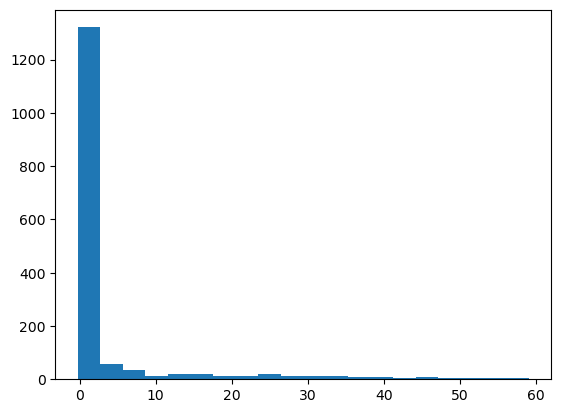

In [29]:
plt.hist(target[20].flatten(), bins = 20)